In [4]:
%pip install pandas matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
# --- Arduino DHT22 → CSV Logger (Jupyter-friendly) ---
# Reads "Temperature_C,Humidity_%" lines from Serial and appends to sleep_data.csv with timestamps.
# Stop the cell to end logging (interrupt/stop button). Requires: pyserial, pandas (optional for preview).

import os, sys, csv, math, time
from datetime import datetime, time as dtime

# Install if missing (uncomment and run once)
# %pip install pyserial

import serial
import serial.tools.list_ports as list_ports

# ====== Config ======
BAUD = 9600                   # must match your Arduino sketch
CSV_PATH = "sleep_data.csv"   # output file
ONLY_NIGHT = False            # set True to keep only 21:00–09:00 samples
NIGHT_START = dtime(21, 0, 0)
NIGHT_END   = dtime(9,  0, 0)

def is_night(ts: datetime) -> bool:
    t = ts.time()
    # window wraps past midnight: 21:00..24:00 OR 00:00..09:00
    return (t >= NIGHT_START) or (t < NIGHT_END)

def list_serial_ports():
    ports = list(list_ports.comports())
    if not ports:
        print("No serial ports found.")
    else:
        print("Available ports:")
        for p in ports:
            print(f"  {p.device:25}  {p.description}")
    return [p.device for p in ports]

def guess_port():
    ports = list(list_ports.comports())
    if not ports:
        # Sane fallbacks by platform
        if sys.platform.startswith("win"):
            return "COM3"
        elif sys.platform == "darwin":
            return "/dev/cu.usbmodem11101"
        else:
            return "/dev/ttyACM0"
    keywords = ["arduino", "nano", "samd", "mkr", "usbmodem", "usbserial", "ttyacm", "ttyusb", "cu.usbmodem", "cu.usbserial"]
    # Try description match first
    for p in ports:
        desc = (p.description or "").lower()
        if any(k in desc for k in keywords):
            return p.device
    # Then device name match
    for p in ports:
        dev = p.device.lower()
        if any(k in dev for k in keywords):
            return p.device
    # Otherwise first port
    return ports[0].device

def parse_csv_line(line: str):
    """
    Accepts lines like '23.4,55.0' and ignores header 'Temperature_C,Humidity_%' or bad/NaN lines.
    Returns (tempC, hum) as floats, or None if invalid.
    """
    parts = [p.strip() for p in line.split(",")]
    if len(parts) != 2:
        return None
    # Ignore header case
    if parts[0].lower().startswith("temperature") or parts[1].lower().startswith("humidity"):
        return None
    try:
        t = float(parts[0])
        h = float(parts[1])
        if math.isnan(t) or math.isnan(h):
            return None
        return t, h
    except Exception:
        return None

# Show ports and pick one
_ = list_serial_ports()
PORT = guess_port()
print(f"Using PORT = {PORT!r}  (change this variable if needed)")

# Open serial
ser = serial.Serial(PORT, BAUD, timeout=1)
print(f"Connected to {ser.name}")

# Prepare CSV file
new_file = not os.path.exists(CSV_PATH)
f = open(CSV_PATH, mode="a", newline="")
writer = csv.writer(f)
if new_file:
    writer.writerow(["Timestamp", "Temperature_C", "Humidity_%"])
print(f"Logging to: {os.path.abspath(CSV_PATH)}")
print("Logging... (Stop the cell to end)")

# Main loop
count = 0
try:
    while True:
        raw = ser.readline().decode("utf-8", errors="ignore").strip()
        if not raw:
            continue
        data = parse_csv_line(raw)
        if data is None:
            continue
        tempC, hum = data
        now = datetime.now()
        if ONLY_NIGHT and not is_night(now):
            continue
        writer.writerow([now.strftime("%Y-%m-%d %H:%M:%S"), f"{tempC:.1f}", f"{hum:.1f}"])
        f.flush(); os.fsync(f.fileno())
        count += 1
        if count % 10 == 0:  # heartbeat every ~10 rows
            print(f"{now:%H:%M:%S}  T={tempC:.1f}°C  H={hum:.1f}%  (saved)")
except KeyboardInterrupt:
    print("\nStopped by user.")
finally:
    try:
        ser.close()
    except Exception:
        pass
    f.close()
    print("Serial closed and file saved.")

Available ports:
  /dev/cu.debug-console      n/a
  /dev/cu.Bluetooth-Incoming-Port  n/a
  /dev/cu.usbmodem11101      Arduino NANO 33 IoT
Using PORT = '/dev/cu.usbmodem11101'  (change this variable if needed)
Connected to /dev/cu.usbmodem11101
Logging to: /Users/arsalansharifizad/Desktop/SIT225/week 9/sleep_data.csv
Logging... (Stop the cell to end)
18:49:20  T=21.7°C  H=49.1%  (saved)
18:49:30  T=21.7°C  H=49.1%  (saved)
18:49:40  T=21.7°C  H=49.2%  (saved)
18:49:50  T=21.6°C  H=49.3%  (saved)
18:50:00  T=21.6°C  H=49.4%  (saved)
18:50:10  T=21.6°C  H=49.3%  (saved)
18:50:20  T=21.6°C  H=49.4%  (saved)
18:50:30  T=21.5°C  H=49.4%  (saved)
18:50:40  T=21.5°C  H=49.5%  (saved)
18:50:50  T=21.5°C  H=49.5%  (saved)
18:51:00  T=21.4°C  H=49.5%  (saved)
18:51:10  T=21.5°C  H=49.4%  (saved)
18:51:20  T=21.4°C  H=49.3%  (saved)
18:51:30  T=21.4°C  H=49.3%  (saved)
18:51:40  T=21.4°C  H=49.4%  (saved)
18:51:50  T=21.4°C  H=49.4%  (saved)
18:52:00  T=21.4°C  H=49.3%  (saved)
18:52:10  T=21.4°C 

SerialException: read failed: [Errno 6] Device not configured


=== Overall stats ===
           metric   min            min_time   max            max_time  \
0  Temperature_C  17.8 2025-09-14 03:07:00  19.1 2025-09-13 21:19:00   
1     Humidity_%  48.5 2025-09-14 08:48:00  52.2 2025-09-14 06:09:00   

        mean  count  
0  18.421927    716  
1  50.417318    716  

=== Daily stats ===
          date  Temperature_min  Temperature_max  Temperature_mean  \
0  2025-09-13             18.1             19.1         18.712222   
1  2025-09-14             17.8             18.8         18.324440   

   Humidity_min  Humidity_max  Humidity_mean  n_points  
0          49.2          51.5      50.276111       180  
1          48.5          52.2      50.464739       536  


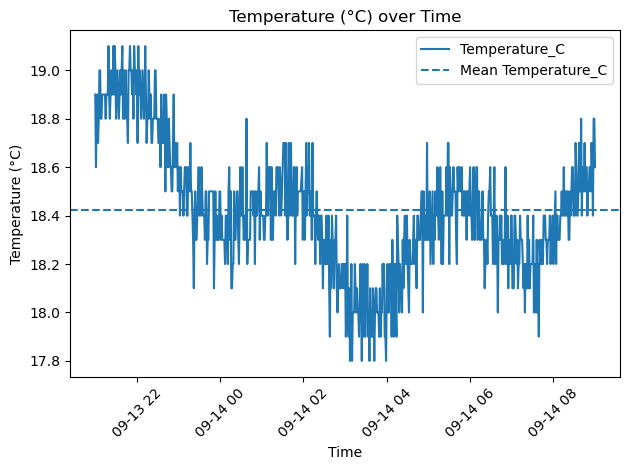

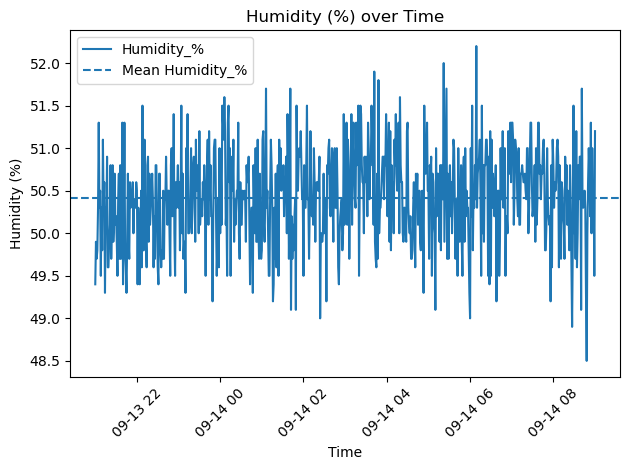

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

CSV_PATH = "day1.csv"   # or your file

# Load + normalize headers
df = pd.read_csv(CSV_PATH)
df.columns = [c.strip().lower() for c in df.columns]
mapping = {
    "timestamp":"Timestamp","time":"Timestamp","ts":"Timestamp","datetime":"Timestamp",
    "temperature_c":"Temperature_C","temperature":"Temperature_C","temp_c":"Temperature_C","temp":"Temperature_C",
    "humidity_%":"Humidity_%","humudity_%":"Humidity_%","humidity":"Humidity_%","rh":"Humidity_%"
}
df = df.rename(columns={c: mapping.get(c, c) for c in df.columns})

# Clean
df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")
df["Temperature_C"] = pd.to_numeric(df["Temperature_C"], errors="coerce")
df["Humidity_%"]    = pd.to_numeric(df["Humidity_%"], errors="coerce")
df = df.dropna(subset=["Timestamp","Temperature_C","Humidity_%"]).sort_values("Timestamp")

# --- overall min/max/mean (with when they happened) ---
def min_with_time(series, ts):
    i = series.idxmin(); return series.loc[i], ts.loc[i]
def max_with_time(series, ts):
    i = series.idxmax(); return series.loc[i], ts.loc[i]

t_min, t_min_t = min_with_time(df["Temperature_C"], df["Timestamp"])
t_max, t_max_t = max_with_time(df["Temperature_C"], df["Timestamp"])
h_min, h_min_t = min_with_time(df["Humidity_%"],    df["Timestamp"])
h_max, h_max_t = max_with_time(df["Humidity_%"],    df["Timestamp"])

overall = pd.DataFrame({
    "metric": ["Temperature_C","Humidity_%"],
    "min": [t_min, h_min], "min_time": [t_min_t, h_min_t],
    "max": [t_max, h_max], "max_time": [t_max_t, h_max_t],
    "mean": [df["Temperature_C"].mean(), df["Humidity_%"].mean()],
    "count":[df["Temperature_C"].count(), df["Humidity_%"].count()]
})
print("\n=== Overall stats ===\n", overall)

# --- daily summary (optional) ---
df["date"] = df["Timestamp"].dt.date
daily = df.groupby("date").agg(
    Temperature_min=("Temperature_C","min"),
    Temperature_max=("Temperature_C","max"),
    Temperature_mean=("Temperature_C","mean"),
    Humidity_min=("Humidity_%","min"),
    Humidity_max=("Humidity_%","max"),
    Humidity_mean=("Humidity_%","mean"),
    n_points=("Timestamp","count")
).reset_index()
print("\n=== Daily stats ===\n", daily)

# Save if you like
overall.to_csv("day1_overall_stats.csv", index=False)
daily.to_csv("day1_daily_stats.csv", index=False)

# --- plots with mean line ---
for col, title, ylab in [
    ("Temperature_C","Temperature (°C) over Time","Temperature (°C)"),
    ("Humidity_%","Humidity (%) over Time","Humidity (%)")
]:
    plt.figure()
    plt.plot(df["Timestamp"], df[col], label=col)
    plt.axhline(df[col].mean(), linestyle="--", label=f"Mean {col}")
    plt.title(title); plt.xlabel("Time"); plt.ylabel(ylab)
    plt.xticks(rotation=45); plt.tight_layout(); plt.legend(); plt.show()

,Day,Temp_mean,Temp_min,Temp_max,Hum_mean,Hum_min,Hum_max,RestScore
0,1,18.42,17.8,19.1,50.42,48.5,52.2,5
1,2,18.60,17.9,19.4,49.97,48.1,51.7,5
2,3,18.78,18.1,19.6,53.99,52.2,55.7,8
3,4,18.37,17.7,19.1,52.97,51.4,54.7,7
4,5,18.71,18.0,19.5,55.08,53.2,56.8,4
5,6,18.78,18.1,19.6,57.61,55.5,59.4,7
6,7,21.95,21.4,22.5,51.78,49.7,53.4,2


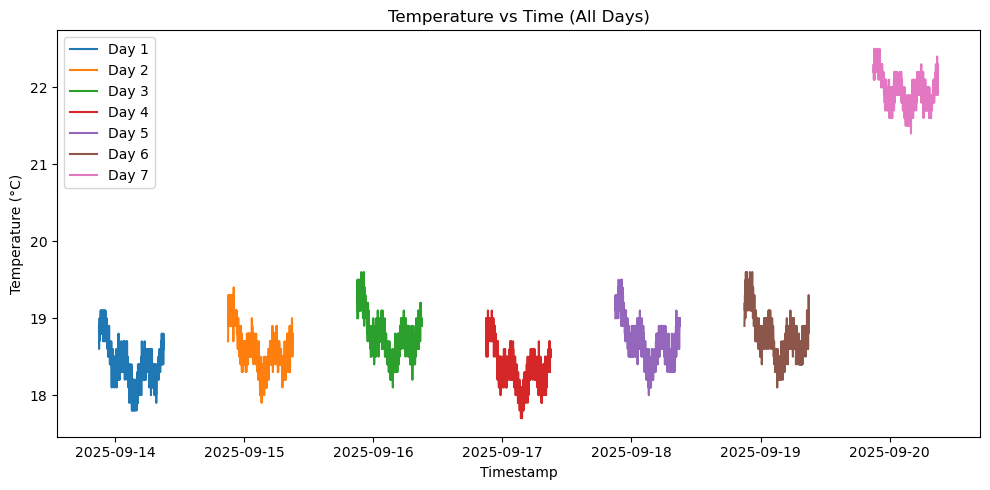

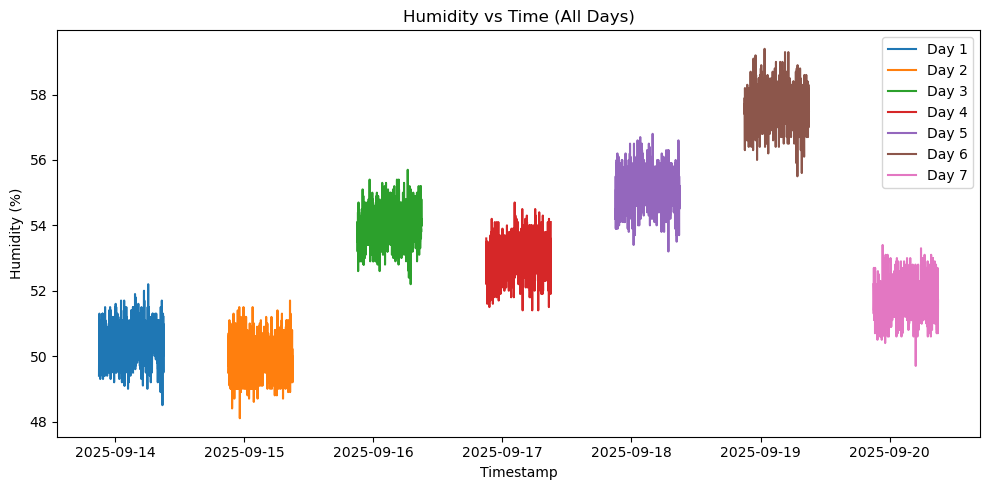

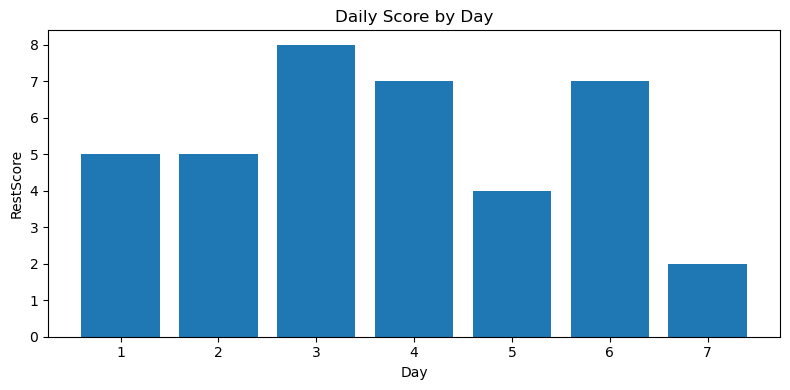

In [34]:
# Minimal, single-cell notebook code
# - Loads day1.csv ... day7.csv  (timestamp, temperature_C, humudity_%)
# - Loads dailyscore.csv         (Day, RestScore)
# - Computes per-day avg/min/max for temp & humidity
# - Plots:
#     1) Temperature vs time (all days)
#     2) Humidity vs time (all days)
#     3) Daily score bar chart
#     4) Temp mean with min–max error bars
#     5) Humidity mean with min–max error bars

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# ---------- FILES IN CURRENT FOLDER ----------
DAY_FILES  = [f"day{i}.csv" for i in range(1, 8)]
SCORES_CSV = "dailyscore.csv"

# ---------- LOAD & CONCAT DAY FILES ----------
frames = []
for i, fname in enumerate(DAY_FILES, start=1):
    d = pd.read_csv(fname)[["timestamp", "temperature_C", "humudity_%"]].copy()
    d["timestamp"] = pd.to_datetime(d["timestamp"])
    d["temperature_C"] = pd.to_numeric(d["temperature_C"], errors="coerce")
    d["humudity_%"]    = pd.to_numeric(d["humudity_%"], errors="coerce")
    d["Day"] = i
    frames.append(d)

raw = pd.concat(frames, ignore_index=True).sort_values(["Day", "timestamp"])

# ---------- DAILY SCORE ----------
scores = pd.read_csv(SCORES_CSV)[["Day", "RestScore"]]

# ---------- PER-DAY STATS ----------
stats = (
    raw.groupby("Day")
       .agg(Temp_mean=("temperature_C", "mean"),
            Temp_min =("temperature_C", "min"),
            Temp_max =("temperature_C", "max"),
            Hum_mean =("humudity_%", "mean"),
            Hum_min  =("humudity_%", "min"),
            Hum_max  =("humudity_%", "max"))
       .reset_index()
)
stats = stats.merge(scores, on="Day", how="left")
display(stats.round(2))

# ---------- PLOTS ----------
# 1) Temperature vs time (all days)
plt.figure(figsize=(10, 5))
for day, d in raw.groupby("Day"):
    dd = d.sort_values("timestamp")
    plt.plot(dd["timestamp"], dd["temperature_C"], label=f"Day {day}")
plt.title("Temperature vs Time (All Days)")
plt.xlabel("Timestamp")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.tight_layout()
plt.show()

# 2) Humidity vs time (all days)
plt.figure(figsize=(10, 5))
for day, d in raw.groupby("Day"):
    dd = d.sort_values("timestamp")
    plt.plot(dd["timestamp"], dd["humudity_%"], label=f"Day {day}")
plt.title("Humidity vs Time (All Days)")
plt.xlabel("Timestamp")
plt.ylabel("Humidity (%)")
plt.legend()
plt.tight_layout()
plt.show()

# 3) Daily score bar chart
plt.figure(figsize=(8, 4))
plt.bar(stats["Day"].astype(str), stats["RestScore"])
plt.title("Daily Score by Day")
plt.xlabel("Day")
plt.ylabel("RestScore")
plt.tight_layout()
plt.show()
